In [1]:
from tqdm import tqdm
from glob import glob
import tifffile
import numpy as np
import os
from EmbedSeg.utils.preprocess_data import extract_data, split_train_val, split_train_crops, get_data_properties
from EmbedSeg.utils.generate_crops import *
from EmbedSeg.utils.visualize import visualize_crop_3d
import json
from matplotlib.colors import ListedColormap

### Download Data

In [2]:
data_dir = '../../../data'
project_name = 'Arabidopsis-Cells-CAM-small'

Ideally, <b>*.tif</b>-type images and the corresponding masks should be respectively present under <b>images</b> and <b>masks</b>, under directories <b>train</b>, <b>val</b> and <b>test</b>, which can be present at any location on your workstation, pointed to by the variable <i>data_dir</i>. (In order to prepare such instance masks, one could use the Fiji plugin <b>Labkit</b> as detailed <a href= "https://github.com/juglab/EmbedSeg/wiki/01---Use-Labkit-to-prepare-instance-masks"> here</a>. The following would be the desired structure as to how data should be present. 

<img src="https://raw.githubusercontent.com/juglab/EmbedSeg/v0.2.4/directory_pngs/png/01_dir_structure.png" width="100"/>

If you already have your data available in the above style, please skip to the <b><a href="#center">third</a></b> section of this notebook, where you specify the kind of center to which constitutive pixels of an object should embed. 

Since for the <b> Arabidopsis-Cells-CAM</b> dataset, we do not have the data in this format yet, we firstly download the data from an external url in the following cells, next we split this data to create our `train`, `val` and `test` directories. 

We use a subset of the original data which originally comes from the publication **<a href= "https://www.pnas.org/doi/full/10.1073/pnas.1616768113">Willis et al, 2016</a>** and **<a href= "https://www.sciencedirect.com/science/article/pii/S1534580721000770?via%3Dihub">Refahi et al, 2021</a>**. 

The images and corresponding masks are downloaded from an external url, specified by `zip_url` to the path specified by the variables `data_dir` and `project_name`. The following structure is generated after executing the `extract_data` and `split_train_val` methods below:

In [3]:
extract_data(
    zip_url = 'https://github.com/juglab/EmbedSeg/releases/download/v0.1.0/Arabidopsis-Cells-CAM-small.zip',
    data_dir = data_dir,
    project_name = project_name,
)

Downloaded data as ../../../data/Arabidopsis-Cells-CAM-small.zip
Unzipped data to ../../../data/Arabidopsis-Cells-CAM-small/download/


In [4]:
split_train_val(
    data_dir = data_dir,
    project_name = project_name, 
    train_val_name = 'train',
    subset = 0.15)

Created new directory : ../../../data/Arabidopsis-Cells-CAM-small/train/images/
Created new directory : ../../../data/Arabidopsis-Cells-CAM-small/train/masks/
Created new directory : ../../../data/Arabidopsis-Cells-CAM-small/val/images/
Created new directory : ../../../data/Arabidopsis-Cells-CAM-small/val/masks/
Created new directory : ../../../data/Arabidopsis-Cells-CAM-small/test/images/
Created new directory : ../../../data/Arabidopsis-Cells-CAM-small/test/masks/
Train-Val-Test Images/Masks copied to ../../../data/Arabidopsis-Cells-CAM-small


### Calculate some dataset specific properties 

In the next cell, we will calculate properties of the data such as `min_object_size`, `foreground_weight` etc. <br>
We will also specify some properties, for example,  

* set `data_properties_dir['data_type']='16-bit'` if the images are of datatype `unsigned 16 bit` and 
    `data_properties_dir['data_type']='8-bit'` if the images are of datatype `unsigned 8 bit`.
    
Ensure that `background_id` should be set to the correct id of the background in the training and val label masks. (By default, this is equal to `0`)  

Lastly, we will save the dictionary `data_properties_dir` in a json file, which we will access in the `02-train` and `03-predict` notebooks.

In [7]:
data_properties_dir = get_data_properties(data_dir, project_name, train_val_name=['train', 'val'], 
                                          test_name=['test'], mode='3d', background_id=1)

data_properties_dir['data_type']='8-bit'
data_properties_dir['pixel_size_x_microns']=0.2415 # set equal to voxel size (microns) in x dimension
data_properties_dir['pixel_size_y_microns']=0.2415 # set equal to voxel size (microns) in y dimension
data_properties_dir['pixel_size_z_microns']=0.2415 # set equal to voxel size (microns) in z dimension

with open('data_properties.json', 'w') as outfile:
    json.dump(data_properties_dir, outfile)
    print("Dataset properies of the `{}` dataset is saved to `data_properties.json`".format(project_name))

100%|███████████████████████████████████████████| 11/11 [00:08<00:00,  1.33it/s]


Foreground weight of the `Arabidopsis-Cells-CAM-small` dataset set equal to 1.662


100%|██████████████████████████████████████████| 11/11 [30:57<00:00, 168.84s/it]


Minimum object size of the `Arabidopsis-Cells-CAM-small` dataset is equal to 148
Mean object size of the `Arabidopsis-Cells-CAM-small` dataset is equal to 17736.18267310253
Maximum object size of the `Arabidopsis-Cells-CAM-small` dataset is equal to 316570
Average object size of the `Arabidopsis-Cells-CAM-small` dataset along `x` is equal to 32.875
Std. dev object size of the `Arabidopsis-Cells-CAM-small` dataset along `x` is equal to 7.139
Average object size of the `Arabidopsis-Cells-CAM-small` dataset along `y` is equal to 32.818
Std. dev object size of the `Arabidopsis-Cells-CAM-small` dataset along `y` is equal to 7.781
Average object size of the `Arabidopsis-Cells-CAM-small` dataset along `z` is equal to 37.825
Std. dev object size of the `Arabidopsis-Cells-CAM-small` dataset along `z` is equal to 12.577


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 18.39it/s]


Tile size of the `Arabidopsis-Cells-CAM-small` dataset set equal to  (n_z = 680, n_y = 680, n_x = 680)


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.71it/s]

Average background intensity of the `Arabidopsis-Cells-CAM-small` dataset set equal to 3.836
Dataset properies of the `Arabidopsis-Cells-CAM-small` dataset is saved to `data_properties.json`


### Specify desired centre location for spatial embedding of pixels

Interior pixels of an object instance can either be embedded at the `centroid` (evaluated in $\mathcal{O(n)}$ operations, where $\mathcal{n}$ is the number of pixels in an object instance), or the `medoid` (evaluated in $\mathcal{O(n^{2})}$ operations). Please note that evaluating `medoid` of the instances could be slow especially if you choose a large `crop_size` later: in such a scenario, a quicker alternative is opting for a higher <b><a href='#speed_up'>`speed_up`</a></b> factor.

In [8]:
center = 'medoid' # 'medoid', 'centroid'
try:
    assert center in {'medoid', 'centroid'}
    print("Spatial Embedding Location chosen as : {}".format(center))
except AssertionError as e:
    e.args += ('Please specify center as one of : {"medoid", "centroid"}', 42)
    raise



Spatial Embedding Location chosen as : medoid


### Specify cropping configuration parameters

Images and the corresponding masks are cropped into patches centred around an object instance, which are pre-saved prior to initiating the training. Note that the cropped images, masks and center-images would be saved at the path specified by `crops_dir` (The parameter `crops_dir` is set to ```./crops``` by default, which creates a directory at the same location as this notebook). Here, `data_subset` defines the directory which is processed. 

Note that we automatically calculate  the `crop_size` by using the `avg_object_size` and `std_object_size` through the relation:
$\text{crop_size_i} = \text{avg_obj_size_i} + \text{n_sigma} \times \text{std_obj_size_i}$ where $i \in \{x,y,z\}$.

One could lower the `n_sigma` factor to $2$ in case the generated crops do not fit on the GPU, later during training.

<a id="speed_up"></a>

In [18]:
n_sigma = 3

In [19]:
def round_up_8(x):
    return (x.astype(int)+7) & (-8)

In [20]:
crops_dir = './crops'
data_subsets = ['train', 'val'] 
crop_size_z = round_up_8(data_properties_dir['avg_object_size_z'] + n_sigma*data_properties_dir['stdev_object_size_z'])
crop_size_y = np.maximum(round_up_8(data_properties_dir['avg_object_size_y'] + n_sigma*data_properties_dir['stdev_object_size_y']),
round_up_8(data_properties_dir['avg_object_size_x'] + n_sigma*data_properties_dir['stdev_object_size_x']))
crop_size_x = crop_size_y
print("Crop size in x and y will be set equal to {}. Crop size in z is set equal to {}".format(crop_size_x, crop_size_z))

Crop size in x and y will be set equal to 56. Crop size in z is set equal to 80


The `anisotropy_factor` is set equal to the ratio of voxel sizes in z to voxel sizes in x or y. <br>
In case, there are out-of-memory issues or cropping takes too long, please try increasing the <b>`speed_up`</b> parameter by steps of 1. <br>

We also generate crops by *downsampling* images and instances in case the data is acquired isotropically. This is just an empirical way to increase the receptive field without using more GPU memory. One doesn't need it if the data is acquired anisotropically along the z-dimnsion.

In [21]:
anisotropy_factor = data_properties_dir['pixel_size_z_microns']/data_properties_dir['pixel_size_x_microns']
speed_up = 2
uniform_ds_factor = 2 if anisotropy_factor == 1 else 1

### Generate Crops

<div class="alert alert-block alert-warning"> 
    The cropped images and masks are saved at the same-location as the example notebooks. <br>
    Generating the crops would take a little while!
</div>

While cropping images, we normalize them by following any one of three strategies: 

(i) `min-max-percentile` (default) 
(ii) `mean-std` 
(iii) `absolute` 

In [22]:
norm = 'min-max-percentile'
try:
    assert norm in {'min-max-percentile', 'mean-std', 'absolute'}
    print("Normalization chosen as : {}".format(norm))
except AssertionError as e:
    e.args += ('Please specify norm as one of : {"min-max-percentile", "mean-std", "absolute"}', 42)
    raise

Normalization chosen as : min-max-percentile


Instead of generating crops from all available objects per image, we only use 10 % of the objects. (See `fraction_max_ids`) <br>
But feel free to set this to $1$ in case of lower number of objects. <br>
Also, since the background label id was set to `1` in the original data, we specify that using `background_id`. <br>
But feel free to set `background_id` to $0$ (which is the default way of specifying the background label id)

In [27]:
for data_subset in data_subsets:
    image_dir = os.path.join(data_dir, project_name, data_subset, 'images')
    instance_dir = os.path.join(data_dir, project_name, data_subset, 'masks')
    image_names = sorted(glob(os.path.join(image_dir, '*.tif'))) 
    instance_names = sorted(glob(os.path.join(instance_dir, '*.tif')))  
    for i in tqdm(np.arange(len(image_names))):
        process_3d(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, 
                crop_size_x = crop_size_x, crop_size_y = crop_size_y, crop_size_z = crop_size_z,
                center = center, anisotropy_factor = anisotropy_factor, speed_up = speed_up, 
                norm=norm, data_type = data_properties_dir['data_type'], uniform_ds_factor=uniform_ds_factor,
                fraction_max_ids=0.1, background_id = 1  
                  )
    print("Cropping of images, instances and centre_images for data_subset = `{}` done!".format(data_subset))

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Created new directory : ./crops/Arabidopsis-Cells-CAM-small/train/images/
Created new directory : ./crops/Arabidopsis-Cells-CAM-small/train/masks/
Created new directory : ./crops/Arabidopsis-Cells-CAM-small/train/center-medoid/


100%|███████████████████████████████████████████| 10/10 [12:50<00:00, 77.10s/it]


Cropping of images, instances and centre_images for data_subset = `train` done!


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Created new directory : ./crops/Arabidopsis-Cells-CAM-small/val/images/
Created new directory : ./crops/Arabidopsis-Cells-CAM-small/val/masks/
Created new directory : ./crops/Arabidopsis-Cells-CAM-small/val/center-medoid/


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.48s/it]

Cropping of images, instances and centre_images for data_subset = `val` done!


### Save `norm` in `normalization.json` file 

In [28]:
normalization = {}
normalization['data_type']=data_properties_dir['data_type']
normalization['norm']=norm
normalization['uniform_ds_factor'] = uniform_ds_factor
with open('normalization.json', 'w') as outfile:
    json.dump(normalization, outfile)
    print("Normalization properties of the `{}` dataset is saved to `normalization.json`".format(project_name))

Normalization properties of the `Arabidopsis-Cells-CAM-small` dataset is saved to `normalization.json`


### Visualize cropped images, corresponding ground truth masks and object center images 

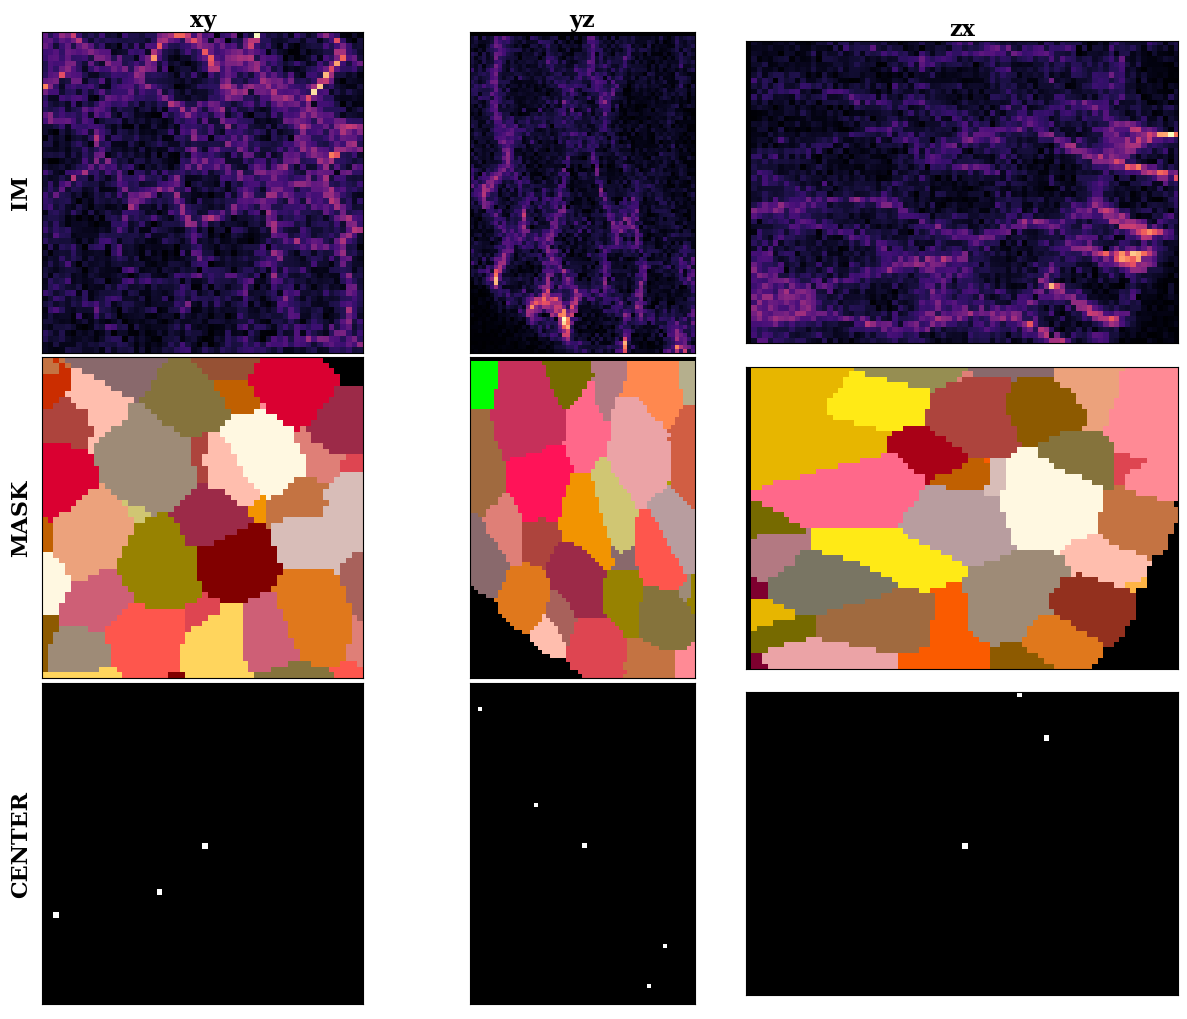

In [29]:
new_cmap = np.load('../../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_crop_3d(data_dir=crops_dir, project_name=project_name, train_val_dir='val', center=center, 
                  new_cmp=new_cmap, anisotropy=anisotropy_factor)